### Stars of the Hipparcos Catalogue
#### Writing an efficient Python code for large data sets

Today, scientists in many areas of research and technology work with big data. The volume of these data sets can even exceed millions of gigabytes. Having fast and reliable computational tools and algorithms is extremely important when working with large data. Luckily Python has some very efficient tools, that we can use to improve the computational performance of the scripts utilizing big data. 

In this notebook, we will explore a large astronomical catalog using various Python commands and find out what stars can tell about their lives. 

We will use the Hipparcos data catalog (<a href="https://www.cosmos.esa.int/web/hipparcos/catalogues">Hipparcos</a>), generated by the Hipparcos satellite (HIgh Precision PARallax COllecting Satellite). The satellite was launched in 1989 by the European Space Agency to measure distances to the stars with higher precision than the previous methods. Although in astronomy today, there are larger and more precise data catalogs, the Hipparcos database remains a good source of information for students trying to understand the distance scale of the Universe and the nature of the famous HR diagram. 
 
The original Hipparcos catalog includes over 70 columns containing different parameters related to the stars' positions, distances, and spectral types. For the analysis, in this notebook, we will use only the following 10 columns:  
<ul>    
<li> Hip_No - unique Hipparcos number </li>
<li> Alpha in (h,m,s) - right ascension of a star
<li> Delta in (d,m,s)- declination </li>
<li> Vmag - visual magnitude as a measure of the apparent stellar brightness 
<li> Plx - trigonometric parallax in milliarcseconds is a small apparent angular shift in the position of a star on the sky due to Earth's motion around the Sun </li>
<li> e_Plx - standard error in Plx in milliarcseconds </li>
<li> B-V - color indexes indicate star's color </li>
<li> e_B-V - standard error for B-V
<li> n_CCDM - historical status flag for the multiple systems. Any of the following letters: H, I or M indicate a double or a multiple systems </li>   
<li> Spectral_type - a spectral type of an object.  This quantity is a measure of the stellar temperature and color. </li>
</ul>

### 1. Importing and preparing data 

First, we will import selected columns from the Hipparcos catalog into a data frame. Then we will prepare the numerical columns by changing their types and examining the size and the type for each column. By selecting only single stars from the catalog we will also reduce the scatter for the HR plot.

In [1]:
#importing Python libraries
import numpy as np
import pandas as pd

file = '../data/hip_sp.csv'

#defining column names
new_column_names = ['Hip_No', 'Alpha', 'Delta','Vmag','Plx', 'e_Plx', 'B-V','e_B-V', 'ccdm_h','Spectral_type']

#importing data
hip_all_stars = pd.read_csv(file, header = None, sep =',',
                usecols = [1,2,3,4,5,6,7,8,9,10],  
                names = new_column_names,
                low_memory = False)

#changing column types: 'coerce' sets invalid parsing to 'NaN'
col_list = ['Vmag', 'Plx', 'e_Plx', 'B-V', 'e_B-V']
for  col in col_list:
   hip_all_stars[col] = pd.to_numeric(hip_all_stars[col],  errors = 'coerce') 

#displaying data frame
hip_all_stars.head(5)

,Hip_No,Alpha,Delta,Vmag,Plx,e_Plx,B-V,e_B-V,ccdm_h,Spectral_type
0,1,00 00 00.22,+01 05 20.4,9.10,3.54,1.39,0.482,0.025,,F5
1,2,00 00 00.91,-19 29 55.8,9.27,21.90,3.10,0.999,0.002,,K3V
2,3,00 00 01.20,+38 51 33.4,6.61,2.81,0.63,-0.019,0.004,I,B9
3,4,00 00 02.01,-51 53 36.8,8.06,7.75,0.97,0.370,0.009,,F0V
4,5,00 00 02.39,-40 35 28.4,8.55,2.87,1.11,0.902,0.013,,G8III


In [2]:
#displaying a summary of a data frame
hip_all_stars.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118218 entries, 0 to 118217
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Hip_No         118218 non-null  int64  
 1   Alpha          118218 non-null  object 
 2   Delta          118218 non-null  object 
 3   Vmag           118217 non-null  float64
 4   Plx            117955 non-null  float64
 5   e_Plx          117955 non-null  float64
 6   B-V            116937 non-null  float64
 7   e_B-V          116937 non-null  float64
 8   ccdm_h         118218 non-null  object 
 9   Spectral_type  118218 non-null  object 
dtypes: float64(5), int64(1), object(4)
memory usage: 9.0+ MB


In [3]:
#selecting only single stars with no ccdm_h flag 
hip = hip_all_stars.loc[hip_all_stars['ccdm_h']==' ']

### 2. Exploring stellar paralaxes 

Trigonometric stellar parallaxes in milliarcseconds are presented in the ['Plx'] column of the data frame. The parallax is an important stellar parameter because it is related to the stellar distance through a simple formula: [distance](in Parsecs) = 1/ [Plx] (in Arcseconds).

The ['Plx'] values are usually small, positive numbers. However, the parallaxes can appear as large numbers or as negative numbers and there are several reasons for that. One of the main reasons for the negative parallaxes is having errors ['e_Plx'] larger than the small values for the parallax or observing stars in the crowded regions of the sky. In any case, we will not consider stars with the negative parallaxes and therefore negative distances. Use the .copy() command when creating a new data frame to explicitly tell pandas that we are making a copy of a data frame. 

In [4]:
#Number of stars with no measured values for the parallax
no_plx = hip['Plx'].isnull().sum()
print('Number of stars without measured parallaxes:{}'.format(no_plx) )

#Number of stars with negative parallaxes
negative_plx= sum([plx<0 for plx in hip['Plx'].values])
print('Number of stars with negative parallaxes:{}'.format(negative_plx) )

#data frame with positive parallaxes
#to prevent the SettingWithCopyWarning due to hidden chaining use .copy()
hip_stars = hip.loc[hip_all_stars['Plx']>0].copy()
hip_stars.shape

Number of stars without measured parallaxes:61
Number of stars with negative parallaxes:3390


(95330, 10)

### 3. Finding absolute stellar magnitudes

In [5]:
#new column with the absolute magnitude

hip_stars['Mv'] = hip_stars['Vmag'] + 5 - 5*np.log10(1000/hip_stars['Plx'])

#rounding using data frame
hip_stars = hip_stars.round({'Mv': 2})

print(hip_stars.shape)
hip_stars.head(5)

(95330, 11)


,Hip_No,Alpha,Delta,Vmag,Plx,e_Plx,B-V,e_B-V,ccdm_h,Spectral_type,Mv
0,1,00 00 00.22,+01 05 20.4,9.10,3.54,1.39,0.482,0.025,,F5,1.85
1,2,00 00 00.91,-19 29 55.8,9.27,21.90,3.10,0.999,0.002,,K3V,5.97
3,4,00 00 02.01,-51 53 36.8,8.06,7.75,0.97,0.370,0.009,,F0V,2.51
4,5,00 00 02.39,-40 35 28.4,8.55,2.87,1.11,0.902,0.013,,G8III,0.84
5,6,00 00 04.35,+03 56 47.4,12.31,18.80,4.99,1.336,0.020,,M0V:,8.68


### 4. Exploring stars in the catalogue

In [6]:
#finding the brightest star in the catalogue
max_magnitude = hip_all_stars.nsmallest(1,'Vmag')

#finding the faintest star in the catalogue
min_magnitude = hip_all_stars.nlargest(1,'Vmag')

#filtering stars brighter than the Sun
bright_df = hip_stars[hip_stars['Mv'] < 4.8]

display(max_magnitude)
display(min_magnitude)
print('Number of stars brighter than the Sun:{}'.format(bright_df.shape[0]))

,Hip_No,Alpha,Delta,Vmag,Plx,e_Plx,B-V,e_B-V,ccdm_h,Spectral_type
32324,32349,06 45 09.25,-16 42 47.3,-1.44,379.21,1.58,0.009,0.007,I,A0m...


,Hip_No,Alpha,Delta,Vmag,Plx,e_Plx,B-V,e_B-V,ccdm_h,Spectral_type
70015,70079,14 20 28.21,-44 31 56.3,14.08,-20.09,12.63,NaN,NaN,,


Number of stars brighter than the Sun:87733


In [7]:
#Creating list of Hipparcos numbers for the stars brighter than the Sun

import timeit

%timeit -r2 -n10 Hip_list1 = [bright_df['Hip_No']]

%timeit -r2 -n10 Hip_list2 = list(bright_df['Hip_No'])

The slowest run took 18.12 times longer than the fastest. This could mean that an intermediate result is being cached.
32.2 µs ± 28.9 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
7.97 ms ± 372 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)


### 5. Difference between Vmag and Mv  

In [8]:
import statistics

#creating list of Vmag
Vmag_list = hip_stars['Vmag']

#spliting hip_star data frame into two dfs
df1 = hip_stars [hip_stars['Vmag'] <= statistics.median(Vmag_list)]
print(df1.shape)
df2 = hip_stars [hip_stars['Vmag'] > statistics.median(Vmag_list)]
print(df2.shape)

#list of absolute magnitudes from the first df
list_1 = df1['Mv']
list_2 = df2['Mv']

set_1 = set(list_1)
set_2 = set(list_2)

(47778, 11)
(47552, 11)


In [9]:
print(len(set_1.intersection(set_2)))
%timeit -r2 -n10 set_1.intersection(set_2)

print(len(set_1.difference(set_2)))
%timeit -r2 -n10 set_1.difference(set_2)

print(len(set_1.union(set_2)))
%timeit -r2 -n10 set_1.union(set_2)

1308
153 µs ± 12.9 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
138
66.7 µs ± 1.91 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
2013
157 µs ± 6.44 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)


### 6. Spectral type of Hipparcos stars

The fastest way of counting how many stars belong to each spectral group is by using a special Python object called Counter. 

In [10]:
from collections import Counter

Sp_list = hip_all_stars['Spectral_type'].str.rstrip()

#create instance of the counter and examining run time
%timeit -r2 -n10 counter_dict = Counter(Sp_list)

#first three spectral groups
counter_dict = Counter(Sp_list)
print(list(counter_dict.items())[:3])

#printing the most common spectral groups 
print(counter_dict.most_common(3))
print(len(counter_dict))

15.4 ms ± 143 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
[('F5', 3861), ('K3V', 216), ('B9', 1581)]
[('K0', 8570), ('G5', 6017), ('A0', 4944)]
4125


### 7. Finding Sun like stars in the catalogue

The best way to find all-stars in the catalog with the spectral type similar to our Sun? The Sun's spectral type is G2V. 

In [11]:
#list comprehension approach
from statistics import mean

hip_sunlike = hip_stars[hip_stars['Spectral_type'].str.strip() == 'G2V']

sunlike_avg = mean(hip_sunlike['Mv'])
print('The average absolute magnitude of the sun-like stars:', 
      round(sunlike_avg, 2), end='\n\n')
display(hip_sunlike.head(5))

The average absolute magnitude of the sun-like stars: 4.01



,Hip_No,Alpha,Delta,Vmag,Plx,e_Plx,B-V,e_B-V,ccdm_h,Spectral_type,Mv
79,80,00 00 58.03,-11 49 24.7,8.40,15.59,1.43,0.566,0.015,,G2V,4.36
393,394,00 04 53.21,+34 39 34.4,6.09,27.18,4.30,0.632,0.011,,G2V,3.26
680,682,00 08 25.69,+06 37 00.5,7.59,25.15,0.97,0.626,0.015,,G2V,4.59
706,705,00 08 47.38,+86 47 16.4,8.41,16.24,0.70,0.588,0.013,,G2V,4.46
844,846,00 10 22.97,-13 59 02.9,8.92,13.53,1.28,0.578,0.003,,G2V,4.58


### 8. Calculating stellar distances

To add the stellar distance as a new column into the existing data frame we need to apply the following formula: 
$$ d = 10^ {(Vmag - Mv +5)*0.2} $$
where Mv is the absolute stellar magnitude, 
Vmag is the apparent stellar magnitude and d is the stellar distance in parsecs (pc). 

In [12]:
hip_stars_d = hip_stars.copy()

%timeit -r2 -n10 hip_stars_d ['Distance'] = 10 **((hip_stars['Vmag'] - hip_stars['Mv']  + 5)*0.2)
hip_stars_d = hip_stars_d.round({'Distance': 2})

1.71 ms ± 348 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)


In [13]:
print(hip_stars_d.shape)
display(hip_stars_d.head(5))

(95330, 12)


,Hip_No,Alpha,Delta,Vmag,Plx,e_Plx,B-V,e_B-V,ccdm_h,Spectral_type,Mv,Distance
0,1,00 00 00.22,+01 05 20.4,9.10,3.54,1.39,0.482,0.025,,F5,1.85,281.84
1,2,00 00 00.91,-19 29 55.8,9.27,21.90,3.10,0.999,0.002,,K3V,5.97,45.71
3,4,00 00 02.01,-51 53 36.8,8.06,7.75,0.97,0.370,0.009,,F0V,2.51,128.82
4,5,00 00 02.39,-40 35 28.4,8.55,2.87,1.11,0.902,0.013,,G8III,0.84,348.34
5,6,00 00 04.35,+03 56 47.4,12.31,18.80,4.99,1.336,0.020,,M0V:,8.68,53.21


### 9. Finding the most distant stars

In [14]:
#selecting stars with the relative errors in parallax: e_Plx/abs(Plx) < 60%
hip_stars_d1 = hip_stars_d.loc[hip_stars_d['e_Plx']/hip_stars_d['Plx'].abs()<0.60]

#print(hip_stars_d1.head(10))
df = hip_stars_d1.sort_values(by=['Distance'], ascending =False)
display(df.head(3))

,Hip_No,Alpha,Delta,Vmag,Plx,e_Plx,B-V,e_B-V,ccdm_h,Spectral_type,Mv,Distance
50070,50108,10 13 49.25,-68 03 35.4,6.73,0.93,0.50,-0.017,0.002,,B6V,-3.43,1076.47
45708,45742,09 19 32.49,-55 11 11.4,6.28,0.95,0.51,-0.099,0.004,,B5V,-3.83,1051.96
48763,48799,09 57 10.95,-52 38 19.7,6.13,0.95,0.48,-0.115,0.004,,B3IV,-3.98,1051.96


### 10. HR - diagram

In [15]:
def HR_plot(col_x, col_y, x_start, x_end, y_start, y_end, clr):
    x = col_x
    y = col_y
    plt.plot(x, y, marker='.', linestyle='none', markersize=2, color=clr)
    plt.xlim(x_start,x_end)
    plt.ylim(y_start,y_end)
    plt.xlabel('B-V')
    plt.ylabel('Mv')
    plt.title('Hipparcos Hertzsprung-Russell Diagram')

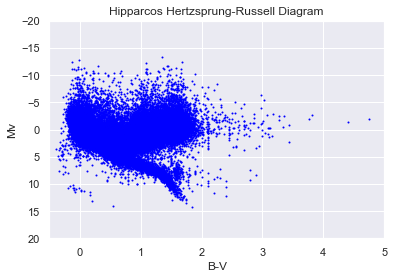

In [16]:
#plotting HR diagram 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

HR_plot(hip_stars['B-V'], hip_stars['Mv'], -0.5, 5, 20, -20, 'blue')    

In [17]:
#selecting stars with the relative errors in parallax: e_Plx/abs(Plx) < 10 %
hip1 = hip_stars.loc[(hip_stars['e_Plx']/hip_stars['Plx'].abs())<0.10]

hip_plot = hip1.loc[hip1['B-V']< 2]

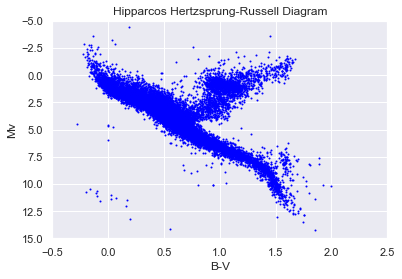

In [18]:
HR_plot(hip_plot['B-V'], hip_plot['Mv'], -0.5, 2.5, 15,-5, 'blue')

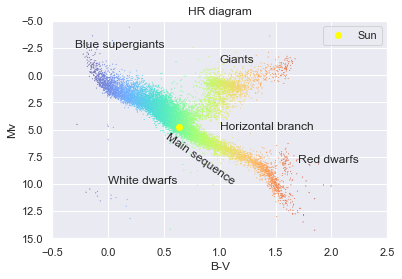

In [19]:
sns.scatterplot(x ='B-V', y ='Mv', data = hip_plot, hue ='B-V', size ='B-V', sizes = (1,1), palette='turbo')

plt.ylim(15,-5)
plt.xlim(-0.5,2.5)
plt.title('HR diagram')
plt.annotate('Main sequence', xy=(0.5,10.0), rotation = -35)
plt.annotate('Giants', xy=(1.0,-1.2))
plt.annotate('Horizontal branch ', xy=(1.0,5.0))
plt.annotate('White dwarfs', xy=(0,10.0))
plt.annotate('Red dwarfs', xy=(1.7,8.0))
plt.annotate('Blue supergiants', xy=(-0.3,-2.5))

#Sun's position at 0.63, 4.8
yellow_dot = plt.plot(0.63,4.8, marker='o', color='yellow', linestyle='none')
plt.legend(yellow_dot, ['Sun'])